The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.2


# Convexity
:label:`sec_convexity`

Convexity plays a vital role in the design of optimization algorithms. 
This is largely due to the fact that it is much easier to analyze and test algorithms in such a context. 
In other words,
if the algorithm performs poorly even in the convex setting,
typically we should not hope to see great results otherwise. 
Furthermore, even though the optimization problems in deep learning are generally nonconvex, they often exhibit some properties of convex ones near local minima. This can lead to exciting new optimization variants such as :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`.


In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

## Definitions

Before convex analysis,
we need to define *convex sets* and *convex functions*.
They lead to mathematical tools that are commonly applied to machine learning.


### Convex Sets

Sets are the basis of convexity. Simply put, a set $\mathcal{X}$ in a vector space is *convex* if for any $a, b \in \mathcal{X}$ the line segment connecting $a$ and $b$ is also in $\mathcal{X}$. In mathematical terms this means that for all $\lambda \in [0, 1]$ we have

$$\lambda  a + (1-\lambda)  b \in \mathcal{X} \text{ whenever } a, b \in \mathcal{X}.$$

This sounds a bit abstract. Consider :numref:`fig_pacman`. The first set is not convex since there exist line segments that are not contained in it.
The other two sets suffer no such problem.

![The first set is nonconvex and the other two are convex.](http://d2l.ai/_images/pacman.svg)
:label:`fig_pacman`

Definitions on their own are not particularly useful unless you can do something with them.
In this case we can look at intersections as shown in :numref:`fig_convex_intersect`.
Assume that $\mathcal{X}$ and $\mathcal{Y}$ are convex sets. Then $\mathcal{X} \cap \mathcal{Y}$ is also convex. To see this, consider any $a, b \in \mathcal{X} \cap \mathcal{Y}$. Since $\mathcal{X}$ and $\mathcal{Y}$ are convex, the line segments connecting $a$ and $b$ are contained in both $\mathcal{X}$ and $\mathcal{Y}$. Given that, they also need to be contained in $\mathcal{X} \cap \mathcal{Y}$, thus proving our theorem.

![The intersection between two convex sets is convex.](../img/convex-intersect.svg)
:label:`fig_convex_intersect`

We can strengthen this result with little effort: given convex sets $\mathcal{X}_i$, their intersection $\cap_{i} \mathcal{X}_i$ is convex.
To see that the converse is not true, consider two disjoint sets $\mathcal{X} \cap \mathcal{Y} = \emptyset$. Now pick $a \in \mathcal{X}$ and $b \in \mathcal{Y}$. The line segment in :numref:`fig_nonconvex` connecting $a$ and $b$ needs to contain some part that is neither in $\mathcal{X}$ nor in $\mathcal{Y}$, since we assumed that $\mathcal{X} \cap \mathcal{Y} = \emptyset$. Hence the line segment is not in $\mathcal{X} \cup \mathcal{Y}$ either, thus proving that in general unions of convex sets need not be convex.

![The union of two convex sets need not be convex.](http://d2l.ai/_images/nonconvex.svg)
:label:`fig_nonconvex`

Typically the problems in deep learning are defined on convex sets. For instance, $\mathbb{R}^d$,
the set of $d$-dimensional vectors of real numbers,
is a convex set (after all, the line between any two points in $\mathbb{R}^d$ remains in $\mathbb{R}^d$). In some cases we work with variables of bounded length, such as balls of radius $r$ as defined by $\{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } \|\mathbf{x}\| \leq r\}$.

### Convex Functions

Now that we have convex sets we can introduce *convex functions* $f$.
Given a convex set $\mathcal{X}$, a function $f: \mathcal{X} \to \mathbb{R}$ is *convex* if for all $x, x' \in \mathcal{X}$ and for all $\lambda \in [0, 1]$ we have

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

To illustrate this let us plot a few functions and check which ones satisfy the requirement.
Below we define a few functions, both convex and nonconvex.


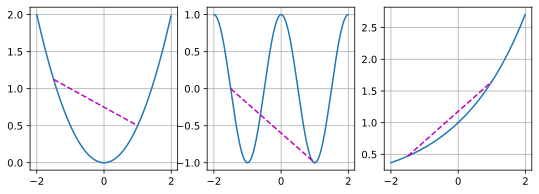

In [2]:
f = lambda x: 0.5 * x**2  # Convex
g = lambda x: torch.cos(np.pi * x)  # Nonconvex
h = lambda x: torch.exp(0.5 * x)  # Convex

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

As expected, the cosine function is *nonconvex*, whereas the parabola and the exponential function are. Note that the requirement that $\mathcal{X}$ is a convex set is necessary for the condition to make sense. Otherwise the outcome of $f(\lambda x + (1-\lambda) x')$ might not be well defined.


### Jensen's Inequality

Given a convex function $f$,
one of the most useful mathematical tools
is *Jensen's inequality*.
It amounts to a generalization of the definition of convexity:

$$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right)    \text{ and }    E_X[f(X)]  \geq f\left(E_X[X]\right),$$
:eqlabel:`eq_jensens-inequality`

where $\alpha_i$ are nonnegative real numbers such that $\sum_i \alpha_i = 1$ and $X$ is a random variable.
In other words, the expectation of a convex function is no less than the convex function of an expectation, where the latter is usually a simpler expression. 
To prove the first inequality we repeatedly apply the definition of convexity to one term in the sum at a time.


One of the common applications of Jensen's inequality is
to bound a more complicated expression by a simpler one.
For example,
its application can be
with regard to the log-likelihood of partially observed random variables. That is, we use

$$E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X),$$

since $\int P(Y) P(X \mid Y) dY = P(X)$.
This can be used in variational methods. Here $Y$ is typically the unobserved random variable, $P(Y)$ is the best guess of how it might be distributed, and $P(X)$ is the distribution with $Y$ integrated out. For instance, in clustering $Y$ might be the cluster labels and $P(X \mid Y)$ is the generative model when applying cluster labels.



## Properties

Convex functions have many useful properties. We describe a few commonly-used ones below.


### Local Minima Are Global Minima

First and foremost, the local minima of convex functions are also the global minima. 
We can prove it by contradiction as follows.

Consider a convex function $f$ defined on a convex set $\mathcal{X}$.
Suppose that $x^{\ast} \in \mathcal{X}$ is a local minimum:
there exists a small positive value $p$ so that for $x \in \mathcal{X}$ that satisfies $0 < |x - x^{\ast}| \leq p$ we have $f(x^{\ast}) < f(x)$.

Assume that the local minimum $x^{\ast}$
is not the global minumum of $f$:
there exists $x' \in \mathcal{X}$ for which $f(x') < f(x^{\ast})$. 
There also exists 
$\lambda \in [0, 1)$ such as $\lambda = 1 - \frac{p}{|x^{\ast} - x'|}$
so that
$0 < |\lambda x^{\ast} + (1-\lambda) x' - x^{\ast}| \leq p$. 

However,
according to the definition of convex functions, we have

$$\begin{aligned}
    f(\lambda x^{\ast} + (1-\lambda) x') &\leq \lambda f(x^{\ast}) + (1-\lambda) f(x') \\
    &< \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \\
    &= f(x^{\ast}),
\end{aligned}$$

which contradicts with our statement that $x^{\ast}$ is a local minimum.
Therefore, there does not exist $x' \in \mathcal{X}$ for which $f(x') < f(x^{\ast})$. The local minimum $x^{\ast}$ is also the global minimum.

For instance, the convex function $f(x) = (x-1)^2$ has a local minimum at $x=1$, which is also the global minimum.


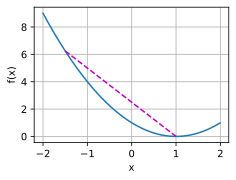

In [3]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

The fact that the local minima for convex functions are also the global minima is very convenient. 
It means that if we minimize functions we cannot "get stuck". 
Note, though, that this does not mean that there cannot be more than one global minimum or that there might even exist one. For instance, the function $f(x) = \mathrm{max}(|x|-1, 0)$ attains its minimum value over the interval $[-1, 1]$. Conversely, the function $f(x) = \exp(x)$ does not attain a minimum value on $\mathbb{R}$: for $x \to -\infty$ it asymptotes to $0$, but there is no $x$ for which $f(x) = 0$.

### Below Sets of Convex Functions Are Convex

We can conveniently 
define convex sets 
via *below sets* of convex functions.
Concretely,
given a convex function $f$ defined on a convex set $\mathcal{X}$,
any below set

$$\mathcal{S}_b := \{x | x \in \mathcal{X} \text{ and } f(x) \leq b\}$$

is convex. 

Let us prove this quickly. Recall that for any $x, x' \in \mathcal{S}_b$ we need to show that $\lambda x + (1-\lambda) x' \in \mathcal{S}_b$ as long as $\lambda \in [0, 1]$. 
Since $f(x) \leq b$ and $f(x') \leq b$,
by the definition of convexity we have 

$$f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b.$$


### Convexity and Second Derivatives

Whenever the second derivative of a function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ exists it is very easy to check whether $f$ is convex. 
All we need to do is check whether the Hessian of $f$ is positive semidefinite: $\nabla^2f \succeq 0$, i.e., 
denoting the Hessian matrix $\nabla^2f$ by $\mathbf{H}$,
$\mathbf{x}^\top \mathbf{H} \mathbf{x} \geq 0$
for all $\mathbf{x} \in \mathbb{R}^n$.
For instance, the function $f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2$ is convex since $\nabla^2 f = \mathbf{1}$, i.e., its Hessian is an identity matrix.


Formally, a twice-differentiable one-dimensional function $f: \mathbb{R} \rightarrow \mathbb{R}$ is convex
if and only if its second derivative $f'' \geq 0$. For any twice-differentiable multi-dimensional function $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$,
it is convex if and only if its Hessian $\nabla^2f \succeq 0$.

First, we need to prove the one-dimensional case.
To see that 
convexity of $f$ implies 
$f'' \geq 0$  we use the fact that

$$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x).$$

Since the second derivative is given by the limit over finite differences it follows that

$$f''(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0.$$

To see that 
$f'' \geq 0$ implies that $f$ is convex
we use the fact that $f'' \geq 0$ implies that $f'$ is a monotonically nondecreasing function. Let $a < x < b$ be three points in $\mathbb{R}$,
where $x = (1-\lambda)a + \lambda b$ and $\lambda \in (0, 1)$.
According to the mean value theorem,
there exist $\alpha \in [a, x]$ and $\beta \in [x, b]$
such that

$$f'(\alpha) = \frac{f(x) - f(a)}{x-a} \text{ and } f'(\beta) = \frac{f(b) - f(x)}{b-x}.$$


By monotonicity $f'(\beta) \geq f'(\alpha)$, hence

$$\frac{x-a}{b-a}f(b) + \frac{b-x}{b-a}f(a) \geq f(x).$$

Since $x = (1-\lambda)a + \lambda b$,
we have

$$\lambda f(b) + (1-\lambda)f(a) \geq f((1-\lambda)a + \lambda b),$$

thus proving convexity.

Second, we need a lemma before 
proving the multi-dimensional case:
$f: \mathbb{R}^n \rightarrow \mathbb{R}$
is convex if and only if for all $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$

$$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y}) \text{ where } z \in [0,1]$$ 

is convex.

To prove that convexity of $f$ implies that $g$ is convex,
we can show that for all $a, b, \lambda \in [0, 1]$ (thus
$0 \leq \lambda a + (1-\lambda) b \leq 1$)

$$\begin{aligned} &g(\lambda a + (1-\lambda) b)\\
=&f\left(\left(\lambda a + (1-\lambda) b\right)\mathbf{x} + \left(1-\lambda a - (1-\lambda) b\right)\mathbf{y} \right)\\
=&f\left(\lambda \left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) \left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \right)\\
\leq& \lambda f\left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) f\left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \\
=& \lambda g(a) + (1-\lambda) g(b).
\end{aligned}$$

To prove the converse,
we can show that for 
all $\lambda \in [0, 1]$ 

$$\begin{aligned} &f(\lambda \mathbf{x} + (1-\lambda) \mathbf{y})\\
=&g(\lambda \cdot 1 + (1-\lambda) \cdot 0)\\
\leq& \lambda g(1)  + (1-\lambda) g(0) \\
=& \lambda f(\mathbf{x}) + (1-\lambda) g(\mathbf{y}).
\end{aligned}$$


Finally,
using the lemma above and the result of the one-dimensional case,
the multi-dimensional case
can be proven as follows.
A multi-dimensional function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ is convex
if and only if for all $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$ $g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y})$, where $z \in [0,1]$,
is convex.
According to the one-dimensional case,
this holds if and only if
$g'' = (\mathbf{x} - \mathbf{y})^\top \mathbf{H}(\mathbf{x} - \mathbf{y}) \geq 0$ ($\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2f$)
for all $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$,
which is equivalent to $\mathbf{H} \succeq 0$
per the definition of positive semidefinite matrices.


## Constraints

One of the nice properties of convex optimization is that it allows us to handle constraints efficiently. That is, it allows us to solve *constrained optimization* problems of the form:

$$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \text{ subject to } & c_i(\mathbf{x}) \leq 0 \text{ for all } i \in \{1, \ldots, n\},
\end{aligned}$$

where $f$ is the objective and the functions $c_i$ are constraint functions. To see what this does consider the case where $c_1(\mathbf{x}) = \|\mathbf{x}\|_2 - 1$. In this case the parameters $\mathbf{x}$ are constrained to the unit ball. If a second constraint is $c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$, then this corresponds to all $\mathbf{x}$ lying on a half-space. Satisfying both constraints simultaneously amounts to selecting a slice of a ball.

### Lagrangian

In general, solving a constrained optimization problem is difficult. One way of addressing it stems from physics with a rather simple intuition. Imagine a ball inside a box. The ball will roll to the place that is lowest and the forces of gravity will be balanced out with the forces that the sides of the box can impose on the ball. In short, the gradient of the objective function (i.e., gravity) will be offset by the gradient of the constraint function (the ball need to remain inside the box by virtue of the walls "pushing back"). 
Note that some constraints may not be active:
the walls that are not touched by the ball
will not be able to exert any force on the ball.


Skipping over the derivation of the *Lagrangian* $L$,
the above reasoning
can be expressed via the following saddle point optimization problem:

$$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n) = f(\mathbf{x}) + \sum_{i=1}^n \alpha_i c_i(\mathbf{x}) \text{ where } \alpha_i \geq 0.$$

Here the variables $\alpha_i$ ($i=1,\ldots,n$) are the so-called *Lagrange multipliers* that ensure that constraints are properly enforced. They are chosen just large enough to ensure that $c_i(\mathbf{x}) \leq 0$ for all $i$. For instance, for any $\mathbf{x}$ where $c_i(\mathbf{x}) < 0$ naturally, we'd end up picking $\alpha_i = 0$. Moreover, this is a saddle point optimization problem where one wants to *maximize* $L$ with respect to all $\alpha_i$ and simultaneously *minimize* it with respect to $\mathbf{x}$. There is a rich body of literature explaining how to arrive at the function $L(\mathbf{x}, \alpha_1, \ldots, \alpha_n)$. For our purposes it is sufficient to know that the saddle point of $L$ is where the original constrained optimization problem is solved optimally.

### Penalties

One way of satisfying constrained optimization problems at least *approximately* is to adapt the Lagrangian $L$. 
Rather than satisfying $c_i(\mathbf{x}) \leq 0$ we simply add $\alpha_i c_i(\mathbf{x})$ to the objective function $f(x)$. This ensures that the constraints will not be violated too badly.

In fact, we have been using this trick all along. Consider weight decay in :numref:`sec_weight_decay`. In it we add $\frac{\lambda}{2} \|\mathbf{w}\|^2$ to the objective function to ensure that $\mathbf{w}$ does not grow too large. From the constrained optimization point of view we can see that this will ensure that $\|\mathbf{w}\|^2 - r^2 \leq 0$ for some radius $r$. Adjusting the value of $\lambda$ allows us to vary the size of $\mathbf{w}$.

In general, adding penalties is a good way of ensuring approximate constraint satisfaction. In practice this turns out to be much more robust than exact satisfaction. Furthermore, for nonconvex problems many of the properties that make the exact approach so appealing in the convex case (e.g., optimality) no longer hold.

### Projections

An alternative strategy for satisfying constraints is projections. Again, we encountered them before, e.g., when dealing with gradient clipping in :numref:`sec_rnn_scratch`. There we ensured that a gradient has length bounded by $\theta$ via

$$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, \theta/\|\mathbf{g}\|).$$

This turns out to be a *projection* of $\mathbf{g}$ onto the ball of radius $\theta$. More generally, a projection on a convex set $\mathcal{X}$ is defined as

$$\mathrm{Proj}_\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in \mathcal{X}} \|\mathbf{x} - \mathbf{x}'\|,$$

which is the closest point in $\mathcal{X}$ to $\mathbf{x}$. 

![Convex Projections.](http://d2l.ai/_images/projections.svg)
:label:`fig_projections`

The mathematical definition of projections may sound a bit abstract. :numref:`fig_projections` explains it somewhat more clearly. In it we have two convex sets, a circle and a diamond. 
Points inside both sets (yellow) remain unchanged during projections. 
Points outside both sets (black) are projected to 
the points inside the sets (red) that are closet to the original points (black).
While for $L_2$ balls this leaves the direction unchanged, this need not be the case in general, as can be seen in the case of the diamond.


One of the uses for convex projections is to compute sparse weight vectors. In this case we project weight vectors onto an $L_1$ ball,
which is a generalized version of the diamond case in :numref:`fig_projections`.


## Summary

In the context of deep learning the main purpose of convex functions is to motivate optimization algorithms and help us understand them in detail. In the following we will see how gradient descent and stochastic gradient descent can be derived accordingly.


* Intersections of convex sets are convex. Unions are not.
* The expectation of a convex function is no less than the convex function of an expectation (Jensen's inequality).
* A twice-differentiable function is convex if and only if its Hessian (a matrix of second derivatives) is positive semidefinite.
* Convex constraints can be added via the Lagrangian. In practice we may simply add them with a penalty to the objective function.
* Projections map to points in the convex set closest to the original points.

## Exercises

1. Assume that we want to verify convexity of a set by drawing all lines between points within the set and checking whether the lines are contained.
    1. Prove that it is sufficient to check only the points on the boundary.
    1. Prove that it is sufficient to check only the vertices of the set.
1. Denote by $\mathcal{B}_p[r] \stackrel{\mathrm{def}}{=} \{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } \|\mathbf{x}\|_p \leq r\}$ the ball of radius $r$ using the $p$-norm. Prove that $\mathcal{B}_p[r]$ is convex for all $p \geq 1$.
1. Given convex functions $f$ and $g$, show that $\mathrm{max}(f, g)$ is convex, too. Prove that $\mathrm{min}(f, g)$ is not convex.
1. Prove that the normalization of the softmax function is convex. More specifically prove the convexity of
    $f(x) = \log \sum_i \exp(x_i)$.
1. Prove that linear subspaces, i.e., $\mathcal{X} = \{\mathbf{x} | \mathbf{W} \mathbf{x} = \mathbf{b}\}$, are convex sets.
1. Prove that in the case of linear subspaces with $\mathbf{b} = \mathbf{0}$ the projection $\mathrm{Proj}_\mathcal{X}$ can be written as $\mathbf{M} \mathbf{x}$ for some matrix $\mathbf{M}$.
1. Show that for  twice-differentiable convex functions $f$ we can write $f(x + \epsilon) = f(x) + \epsilon f'(x) + \frac{1}{2} \epsilon^2 f''(x + \xi)$ for some $\xi \in [0, \epsilon]$.
1. Given a vector $\mathbf{w} \in \mathbb{R}^d$ with $\|\mathbf{w}\|_1 > 1$ compute the projection on the $L_1$ unit ball.
    1. As an intermediate step write out the penalized objective $\|\mathbf{w} - \mathbf{w}'\|^2 + \lambda \|\mathbf{w}'\|_1$ and compute the solution for a given $\lambda > 0$.
    1. Can you find the "right" value of $\lambda$ without a lot of trial and error?
1. Given a convex set $\mathcal{X}$ and two vectors $\mathbf{x}$ and $\mathbf{y}$, prove that projections never increase distances, i.e., $\|\mathbf{x} - \mathbf{y}\| \geq \|\mathrm{Proj}_\mathcal{X}(\mathbf{x}) - \mathrm{Proj}_\mathcal{X}(\mathbf{y})\|$.


[Discussions](https://discuss.d2l.ai/t/350)
